In [1]:
#https://github.com/Cdiscount/IT-Blog/blob/master/samples/DataScience/pos-tagging-neural-nets-keras/pos_tagging_neural_nets_keras.ipynb

In [2]:
# Ensure reproducibility
import numpy as np

CUSTOM_SEED = 42
np.random.seed(CUSTOM_SEED)

import nltk
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:
from nltk.corpus import treebank
import random

sentences = treebank.tagged_sents(tagset='universal')
print('a random sentence: \n-> {}'.format(random.choice(sentences)))

for list_dat in treebank.sents()[0:10]:
    print(' '.join(list_dat))

sen_len = len(sentences)
print('sen_len:', sen_len)
sentences = sentences[0: int(sen_len/2)]

a random sentence: 
-> [('Foreigners', 'NOUN'), ('complain', 'VERB'), ('that', 'ADP'), ('they', 'PRON'), ('have', 'VERB'), ('limited', 'ADJ'), ('access', 'NOUN'), ('to', 'PRT'), ('government', 'NOUN'), ('procurement', 'NOUN'), ('in', 'ADP'), ('Japan', 'NOUN'), (',', '.'), ('in', 'ADP'), ('part', 'NOUN'), ('because', 'ADP'), ('Japanese', 'ADJ'), ('companies', 'NOUN'), ('unfairly', 'ADV'), ('undercut', 'VERB'), ('them', 'PRON'), ('.', '.')]
Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 .
Mr. Vinken is chairman of Elsevier N.V. , the Dutch publishing group .
Rudolph Agnew , 55 years old and former chairman of Consolidated Gold Fields PLC , was named *-1 a nonexecutive director of this British industrial conglomerate .
A form of asbestos once used * * to make Kent cigarette filters has caused a high percentage of cancer deaths among a group of workers exposed * to it more than 30 years ago , researchers reported 0 *T*-1 .
The asbestos fiber , crocido

In [4]:
tags = set([tag for sentence in treebank.tagged_sents() for _, tag in sentence])
print('nb_tags: {}\ntags: {}'.format(len(tags), tags))

nb_tags: 46
tags: {'CC', 'WDT', '-NONE-', 'UH', 'NNP', '#', '.', 'WP$', 'NN', 'MD', '-LRB-', 'VB', 'JJS', "''", ',', 'JJR', 'SYM', 'WP', 'JJ', 'POS', 'PRP', 'PRP$', 'NNS', 'VBG', 'DT', 'FW', 'TO', 'RBR', 'IN', 'PDT', 'VBN', '``', 'RP', 'VBD', 'WRB', 'RBS', 'VBP', 'LS', '-RRB-', 'NNPS', ':', 'EX', 'RB', '$', 'VBZ', 'CD'}


In [5]:
train_test_cutoff = int(.70 * len(sentences)) 
training_sentences = sentences[:train_test_cutoff]
testing_sentences = sentences[train_test_cutoff:]
 
train_val_cutoff = int(.30 * len(training_sentences))
validation_sentences = training_sentences[:train_val_cutoff]
training_sentences = training_sentences[train_val_cutoff:]

print(training_sentences[0])

[('The', 'DET'), ('government', 'NOUN'), ('includes', 'VERB'), ('money', 'NOUN'), ('spent', 'VERB'), ('*', 'X'), ('on', 'ADP'), ('residential', 'ADJ'), ('renovation', 'NOUN'), (';', '.'), ('Dodge', 'NOUN'), ('does', 'VERB'), ("n't", 'ADV'), ('*?*', 'X'), ('.', '.')]


In [18]:
print(len(training_sentences))

959


In [6]:
def add_basic_features(sentence_terms, index):
    """ Compute some very basic word features.

        :param sentence_terms: [w1, w2, ...] 
        :type sentence_terms: list
        :param index: the index of the word 
        :type index: int
        :return: dict containing features
        :rtype: dict
    """
    term = sentence_terms[index]
    return {
        'nb_terms': len(sentence_terms),
        'term': term,
        'is_first': index == 0,
        'is_last': index == len(sentence_terms) - 1,
        'is_capitalized': term[0].upper() == term[0],
        'is_all_caps': term.upper() == term,
        'is_all_lower': term.lower() == term,
        'prefix-1': term[0],
        'prefix-2': term[:2],
        'prefix-3': term[:3],
        'suffix-1': term[-1],
        'suffix-2': term[-2:],
        'suffix-3': term[-3:],
        'prev_word': '' if index == 0 else sentence_terms[index - 1],
        'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
    }

def untag(tagged_sentence):
    """ 
    Remove the tag for each tagged term. 

    :param tagged_sentence: a POS tagged sentence
    :type tagged_sentence: list
    :return: a list of tags
    :rtype: list of strings
    """
    return [w for w, _ in tagged_sentence]

def transform_to_dataset(tagged_sentences):
    """
    Split tagged sentences to X and y datasets and append some basic features.

    :param tagged_sentences: a list of POS tagged sentences
    :param tagged_sentences: list of list of tuples (term_i, tag_i)
    :return: 
    """
    X, y = [], []

    for pos_tags in tagged_sentences:
        for index, (term, class_) in enumerate(pos_tags):
            # Add basic NLP features for each sentence term
            X.append(add_basic_features(untag(pos_tags), index))
            y.append(class_)
    return X, y

In [7]:
print(untag(training_sentences[0]))

print(add_basic_features(untag(training_sentences[0]), 0))

# a, b = [], []
# a, b = transform_to_dataset(training_sentences[0])
# print(a)
# print(b)

['The', 'government', 'includes', 'money', 'spent', '*', 'on', 'residential', 'renovation', ';', 'Dodge', 'does', "n't", '*?*', '.']
{'nb_terms': 15, 'term': 'The', 'is_first': True, 'is_last': False, 'is_capitalized': True, 'is_all_caps': False, 'is_all_lower': False, 'prefix-1': 'T', 'prefix-2': 'Th', 'prefix-3': 'The', 'suffix-1': 'e', 'suffix-2': 'he', 'suffix-3': 'The', 'prev_word': '', 'next_word': 'government'}


In [8]:
X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(testing_sentences)
X_val, y_val = transform_to_dataset(validation_sentences)

print('', len(X_train))
print('', X_train[0:10])
print('', len(y_train)) #, ' ,y_train.shape[1]:', y_train.shape[1])
print('', y_train[0:10])

 24541
 [{'nb_terms': 15, 'term': 'The', 'is_first': True, 'is_last': False, 'is_capitalized': True, 'is_all_caps': False, 'is_all_lower': False, 'prefix-1': 'T', 'prefix-2': 'Th', 'prefix-3': 'The', 'suffix-1': 'e', 'suffix-2': 'he', 'suffix-3': 'The', 'prev_word': '', 'next_word': 'government'}, {'nb_terms': 15, 'term': 'government', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'is_all_caps': False, 'is_all_lower': True, 'prefix-1': 'g', 'prefix-2': 'go', 'prefix-3': 'gov', 'suffix-1': 't', 'suffix-2': 'nt', 'suffix-3': 'ent', 'prev_word': 'The', 'next_word': 'includes'}, {'nb_terms': 15, 'term': 'includes', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'is_all_caps': False, 'is_all_lower': True, 'prefix-1': 'i', 'prefix-2': 'in', 'prefix-3': 'inc', 'suffix-1': 's', 'suffix-2': 'es', 'suffix-3': 'des', 'prev_word': 'government', 'next_word': 'money'}, {'nb_terms': 15, 'term': 'money', 'is_first': False, 'is_last': False, 'is_capitalized': False, 'is_a

In [9]:
from sklearn.feature_extraction import DictVectorizer
 
dict_vectorizer = DictVectorizer(sparse=False)
dict_vectorizer.fit(X_train + X_test + X_val)

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
               sparse=False)

In [10]:
X_train = dict_vectorizer.transform(X_train)
X_test = dict_vectorizer.transform(X_test)
X_val = dict_vectorizer.transform(X_val)

print('', X_train.shape)
print('', X_train[0:10])

 (24541, 31100)
 [[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test + y_val)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

print('', y_train[0:10])
print(len(list(set(y_train))))

 [ 5  6 10  6 10 11  2  1  6  0]
12


In [12]:
from keras.utils import np_utils
 
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

def build_model(input_dim, hidden_neurons, output_dim):
    """
    Construct, compile and return a Keras model which will be used to fit/predict
    """
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

from keras.wrappers.scikit_learn import KerasClassifier

model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 512,
    'output_dim': y_train.shape[1],
    'epochs': 5,
    'batch_size': 256,
    'verbose': 1,
    'validation_data': (X_val, y_val),
    'shuffle': True
}

clf = KerasClassifier(**model_params)
hist = clf.fit(X_train, y_train)

Epoch 1/5
96/96 [==============================] - 6s 61ms/step - loss: 0.7263 - accuracy: 0.7912 - val_loss: 0.1999 - val_accuracy: 0.9359
Epoch 2/5
96/96 [==============================] - 5s 52ms/step - loss: 0.1190 - accuracy: 0.9641 - val_loss: 0.1753 - val_accuracy: 0.9441
Epoch 3/5
96/96 [==============================] - 5s 52ms/step - loss: 0.0577 - accuracy: 0.9831 - val_loss: 0.1714 - val_accuracy: 0.9491
Epoch 4/5
96/96 [==============================] - 5s 52ms/step - loss: 0.0330 - accuracy: 0.9901 - val_loss: 0.1939 - val_accuracy: 0.9442
Epoch 5/5
96/96 [==============================] - 5s 50ms/step - loss: 0.0204 - accuracy: 0.9936 - val_loss: 0.1859 - val_accuracy: 0.9499


In [14]:
import matplotlib.pyplot as plt

def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """

    green = '#72C29B'
    orange = '#FFA577'

    with plt.xkcd():
        fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
        ax1.plot(range(1, len(train_loss) + 1), train_loss, green, linewidth=5,
                 label='training')
        ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, orange,
                 linewidth=5, label='validation')
        ax1.set_xlabel('# epoch')
        ax1.set_ylabel('loss')
        ax1.tick_params('y')
        ax1.legend(loc='upper right', shadow=False)
        ax1.set_title('Model loss through #epochs', fontweight='bold')

        ax2.plot(range(1, len(train_acc) + 1), train_acc, green, linewidth=5,
                 label='training')
        ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, orange,
                 linewidth=5, label='validation')
        ax2.set_xlabel('# epoch')
        ax2.set_ylabel('accuracy')
        ax2.tick_params('y')
        ax2.legend(loc='lower right', shadow=False)
        ax2.set_title('Model accuracy through #epochs', fontweight='bold')

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


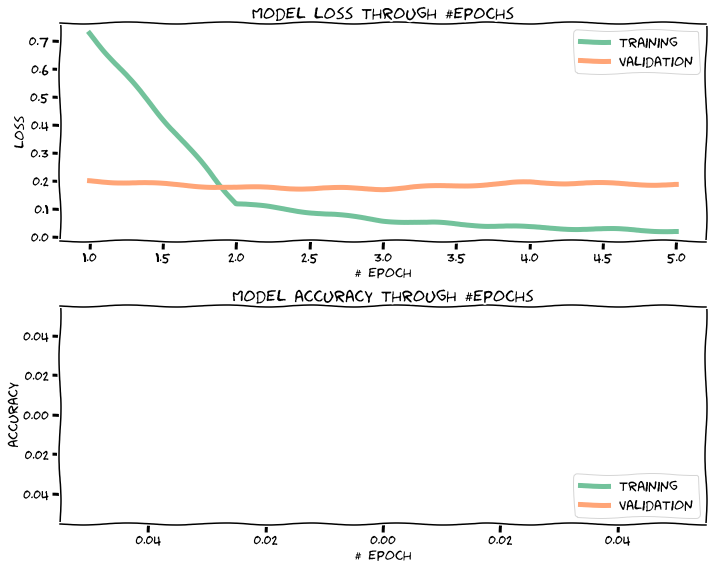

In [15]:
plot_model_performance(
    train_loss=hist.history.get('loss', []),
    train_acc=hist.history.get('acc', []),
    train_val_loss=hist.history.get('val_loss', []),
    train_val_acc=hist.history.get('val_acc', [])
)

In [16]:
score = clf.score(X_test, y_test, verbose=0)    
print('model accuracy: {}'.format(score))

model accuracy: 0.9473750591278076


In [17]:
#clf.model.save('/tmp/keras_mlp.h5')